# Neural Architecture Search with Multiple Input Tensors

In this tutorial we will extend on the previous [basic NAS tutorial](https://deephyper.readthedocs.io/en/latest/tutorials/tutorials/notebooks/04_NAS_basic/tutorial_04.html) to allow for varying numbers of input tensors. This calls for the construction of a novel search space where the different input tensors may be connected to any of the variable node operations within the search space. The data use for this tutorial is provided in this repository and is a multifidelity surrogate modeling data set obtained from the [Brannin function](https://www.sfu.ca/~ssurjano/branin.html). In addition, to the independent variables for this modeling task, low and medium fidelity estimates of the output variable are used as additional inputs to the eventual high fidelity surrogate. Thus, this requires multiple input tensors which may independently or jointly interact with the neural architecture.

In [1]:
!pip install deephyper["nas"]
!pip install Pillow

## Data from Brannin Function
First, we will look at the `load_data` function that loads and returns the training and validation data from the multifidelity [Brannin function](https://www.sfu.ca/~ssurjano/branin.html). This dataset is provided in the [deephyper/tutorials repository](https://github.com/deephyper/tutorials).


The output interface of the ``load_data`` function is important when you have several inputs or outputs. In this case, for the inputs we have a list of 3 numpy arrays.

In [1]:
import numpy as np


def load_data():
    """Here we are loading data that has multiple inputs for the same output.
    Our goal is to not make ONE tensor with all inputs but have separate input tensors.
    """

    data = np.load("data.npz") # Data from the Brannin function

    xtrain = data["xtrain"]  # Independent variables (input tensor 1)
    ytrain_lf = data["ytrain_lf"]  # Low fidelity variable (input tensor 2)
    ytrain_mf = data["ytrain_mf"]  # Medium fidelity variable (input tensor 3)
    ytrain_hf = data["ytrain_hf"]  # High fidelity variable (output tensor)

    xtest = data["xtest"]
    ytest_lf = data["ytest_lf"]
    ytest_mf = data["ytest_mf"]
    ytest_hf = data["ytest_hf"]

    return ([xtrain, ytrain_lf, ytrain_mf], ytrain_hf), ([xtest, ytest_lf, ytest_mf], ytest_hf)

## Neural Architecture Search Space

Now we define a neural architecture search space with multiple inputs. In the `build(self,...)` method we can see that 3 input nodes are automatically created based on the defined `input_shape`:

```python
...
self = KSearchSpace(input_shape, output_shape)

# Three input tensors are automatically created based on the `input_shape`
input_0, input_1, input_2 = self.input_nodes
...
```

In [2]:
import collections

import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Dense = operation(tf.keras.layers.Dense)
Concatenate = operation(tf.keras.layers.Concatenate)


class MultiInputsResNetMLPFactory(KSearchSpace):

    def __init__(self, input_shape, output_shape, seed=None, num_layers=3, mode="regression"):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = num_layers
        assert mode in ["regression", "classification"]
        self.mode = mode

    def build(self):

        assert len(self.input_shape) == 3

        # Three input tensors are automatically created based on the `input_shape`
        input_0, input_1, input_2 = self.input_nodes

        concat = ConstantNode(Concatenate())
        self.connect(input_0, concat)
        self.connect(input_1, concat)
        self.connect(input_2, concat)

        # Input anchors (recorded so they can be connected to anywhere
        # in the architecture)
        input_anchors = [input_1, input_2]

        # Creates a Queue to store outputs of the 3 previously created  layers
        # to create potential residual connections
        skip_anchors = collections.deque([input_0], maxlen=3)

        prev_input = concat
        for _ in range(self.num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)
            self.connect(prev_input, dense)

            # ConstantNode to merge possible residual connections from the different
            # input tensors (input_0, input_1, input_2)
            merge_0 = ConstantNode()
            merge_0.set_op(AddByProjecting(self, [dense], activation="relu"))

            # Creates potential connections to the various input tensors
            for anchor in input_anchors:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, merge_0)

            # ConstantNode to merge possible
            merge_1 = ConstantNode()
            merge_1.set_op(AddByProjecting(self, [merge_0], activation="relu"))

            # a potential connection to the variable nodes (vnodes) of the previous layers
            for anchor in skip_anchors:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, merge_1)

            # ! for next iter
            prev_input = merge_1
            skip_anchors.append(prev_input)

        if self.mode == "regression":
            output_node = ConstantNode(Dense(self.output_shape[0]))
            self.connect(prev_input, output_node)
        else:
            output_node = ConstantNode(Dense(self.output_shape[0], activation="softmax"))
            self.connect(prev_input, output_node)
        
        return self

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case

        activations = [
            tf.keras.activations.linear,
            tf.keras.activations.relu,
            tf.keras.activations.tanh,
            tf.keras.activations.sigmoid,
        ]
        for units in range(16, 97, 16):
            for activation in activations:
                node.add_op(Dense(units=units, activation=activation))

Visualize a randomly generated neural network from this search space:

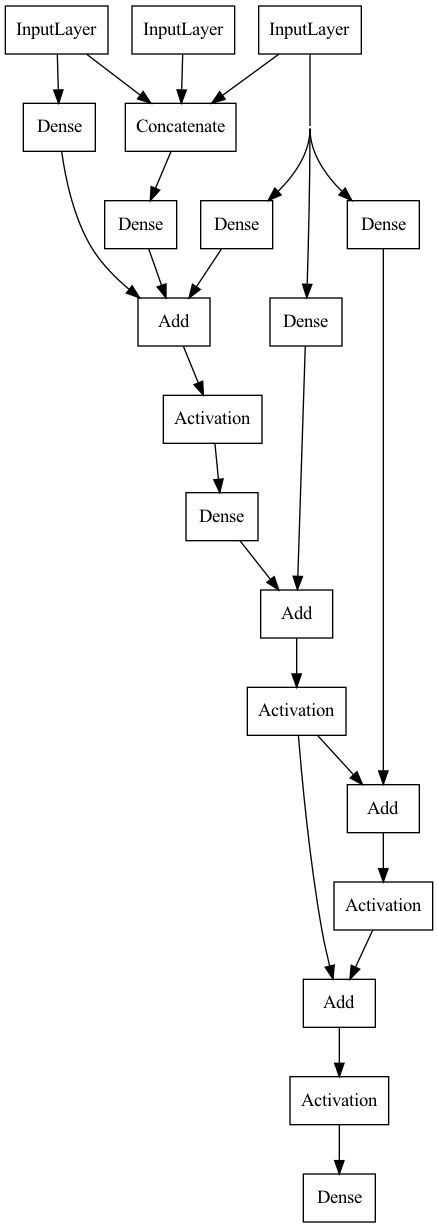

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=[(2,), (1,), (1,)], output_shape=(1,))
space = MultiInputsResNetMLPFactory(**shapes, num_layers=3).build()
model = space.sample()
plot_model(model, show_shapes=False, show_layer_names=False) 

## Neural Architecture Search Problem

Now, let us define the neural architecture search problem:

In [4]:
from deephyper.problem import NaProblem

problem = NaProblem()

problem.load_data(load_data)

problem.search_space(MultiInputsResNetMLPFactory, num_layers=3)

problem.hyperparameters(
    batch_size=64,
    learning_rate=0.001,
    optimizer="adam",
    epsilon=1e-7,
    num_epochs=200,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5  # or 'val_acc' ?
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem.loss("mse")

problem.metrics(["r2"])

problem.objective("val_r2")

problem

Problem is:
    - search space   : __main__.MultiInputsResNetMLPFactory
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 64
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 200
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}, 'ModelCheckpoint': {'monitor': 'val_loss', 'mode': 'min', 'save_best_only': True, 'verbose': 0, 'filepath': 'model.h5', 'save_weights_only': False}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2

## Running the Search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function defined previously.

In [5]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.nas.run import run_base_trainer

evaluator = Evaluator.create(run_base_trainer,
                             method="ray",
                             method_kwargs={
                                 "address": None,
                                 "num_cpus": 2,
                                 "num_cpus_per_task": 1,
                                 "callbacks": [TqdmCallback()]
                             })

print("Number of workers: ", evaluator.num_workers)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:99: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


Number of workers:  2


Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [7]:
from deephyper.search.nas import Random

search = Random(problem, evaluator)

In [8]:
results = search.search(10)

(run_base_trainer pid=8790) 2022-06-07 16:38:32.147236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
(run_base_trainer pid=8790) 2022-06-07 16:38:32.148403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
(run_base_trainer pid=8791) 2022-06-07 16:38:32.189391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
(run_base_trainer pid=8791) 2022-06-07 16:38:32.190768: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
(run_base_trainer pid=8790) /Users/romainegele/miniforge3/envs/dh-env-test/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
(run_base_trainer pid=8790)  

## Analyse the Results

In [9]:
results

,arch_seq,job_id,objective,timestamp_submit,timestamp_gather
0,"[24, 1, 1, 0, 10, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1]",2,-7.614659,26.822817,29.673541
1,"[22, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1]",3,0.249594,29.687959,32.668731
2,"[6, 1, 1, 0, 12, 1, 0, 0, 0, 17, 1, 1, 0, 1, 0]",4,-8.233507,32.670413,33.201887
3,"[5, 0, 0, 1, 0, 0, 1, 1, 1, 18, 1, 0, 0, 0, 0]",1,0.770399,26.822748,33.206627
4,"[13, 0, 0, 1, 17, 0, 0, 0, 1, 16, 0, 1, 1, 1, 0]",6,0.494407,33.207587,38.395773
5,"[4, 0, 0, 1, 23, 0, 1, 1, 1, 16, 1, 0, 0, 1, 0]",5,0.505155,33.203239,38.693435
6,"[15, 1, 0, 1, 3, 0, 0, 1, 1, 8, 1, 1, 1, 1, 1]",7,0.501822,38.397072,41.333961
7,"[6, 1, 0, 0, 9, 1, 0, 1, 1, 22, 0, 1, 1, 0, 0]",9,0.534914,41.335397,44.462950
8,"[9, 0, 1, 1, 23, 1, 1, 1, 1, 11, 1, 0, 1, 0, 0]",8,-0.644934,38.695095,46.391974
9,"[10, 0, 1, 0, 18, 0, 0, 1, 0, 17, 1, 0, 0, 0, 1]",10,0.617369,44.464504,46.677372


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [10]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[5, 0, 0, 1, 0, 0, 1, 1, 1, 18, 1, 0, 0, 0, 0]'
  job_id: 1
  objective: 0.770398736
  timestamp_gather: 33.2066268921
  timestamp_submit: 26.8227479458
'1':
  arch_seq: '[10, 0, 1, 0, 18, 0, 0, 1, 0, 17, 1, 0, 0, 0, 1]'
  job_id: 10
  objective: 0.6173686981
  timestamp_gather: 46.6773719788
  timestamp_submit: 44.4645040035
'2':
  arch_seq: '[6, 1, 0, 0, 9, 1, 0, 1, 1, 22, 0, 1, 1, 0, 0]'
  job_id: 9
  objective: 0.5349139571
  timestamp_gather: 44.4629499912
  timestamp_submit: 41.3353970051



Output the best neural network architecture:

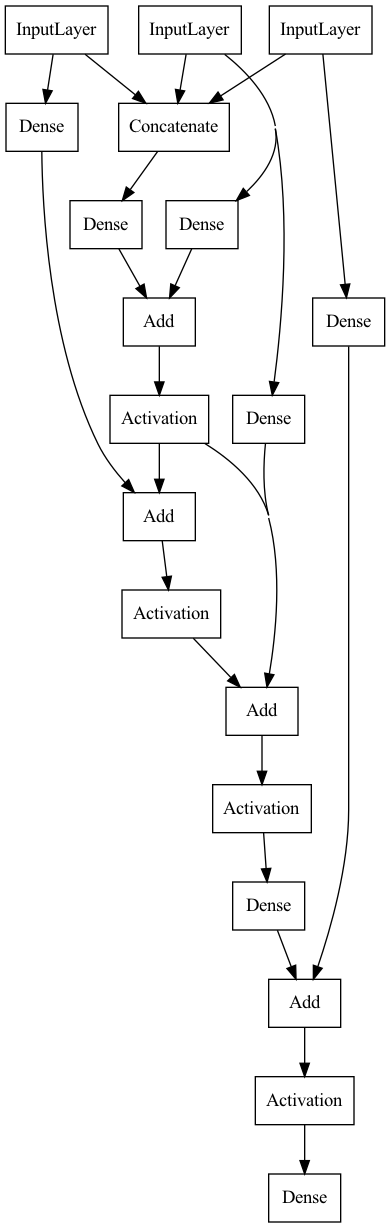

In [11]:
import json

best_config = results.iloc[results.objective.argmax()][:-3].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
model = space.sample(arch_seq)
plot_model(model, show_shapes=False, show_layer_names=False) 